In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [3]:
def plot_series(time, series, format='-', start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize=6)
  plt.grid(True)

def trend(time, slope=0):
  return time*slope

def seasonal_pattern(seasonal_time):
  return np.where(seasonal_time<0.4,
                  np.cos(seasonal_time*2*np.pi),
                  1/np.exp(3*seasonal_time))

def seasonality(time, period, amplitude=1, phase=0):
  seasonal_time = ((time+phase)%period)/period
  return amplitude*seasonal_pattern(seasonal_time)

def white_noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time))*noise_level

def seq2seq_window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda window: (window[:-1], window[-1:]))
  return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

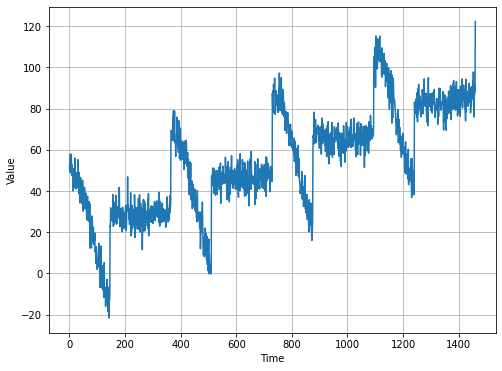

In [4]:
time = np.arange(4*365+1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline+trend(time, slope)+seasonality(time, period=365, amplitude=amplitude)

noise_level=5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(8,6))
plot_series(time, series)
plt.show()

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
                                 keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None,1]),
                                 keras.layers.LSTM(32, return_sequences=True),
                                 keras.layers.LSTM(32, return_sequences=True),
                                 keras.layers.Dense(1),
                                 keras.layers.Lambda(lambda x: x*200)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-08, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 14s 131ms/step - loss: 88.0758 - mae: 88.5756 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 87.3711 - mae: 87.8708 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 86.1982 - mae: 86.6979 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 84.6643 - mae: 85.1640 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 82.8054 - mae: 83.3050 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 18ms/step - loss: 80.6101 - mae: 81.1097 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 21ms/step - loss: 78.1490 - mae: 78.6487 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 16ms/step - loss: 75.5228 - mae: 76.0225 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 17ms/step - loss: 72.8996 - mae: 73.3993 - lr: 2.

(1e-08, 0.0001, 0.0, 30.0)

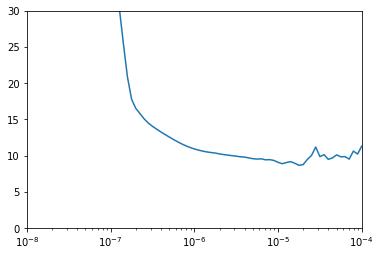

In [7]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
                                 keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None,1]),
                                 keras.layers.LSTM(32, return_sequences=True),
                                 keras.layers.LSTM(32, return_sequences=True),
                                 keras.layers.Dense(1),
                                 keras.layers.Lambda(lambda x: x*200)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-06, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_checkpoint.h5', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 4s 174ms/step - loss: 86.6010 - mae: 87.1006 - val_loss: 108.0991 - val_mae: 108.5991
Epoch 2/500
8/8 [==============================] - 0s 23ms/step - loss: 37.7973 - mae: 38.2945 - val_loss: 33.2958 - val_mae: 33.7931
Epoch 3/500
8/8 [==============================] - 0s 33ms/step - loss: 31.0727 - mae: 31.5702 - val_loss: 33.5032 - val_mae: 34.0013
Epoch 4/500
8/8 [==============================] - 0s 20ms/step - loss: 23.3396 - mae: 23.8361 - val_loss: 52.4943 - val_mae: 52.9939
Epoch 5/500
8/8 [==============================] - 1s 40ms/step - loss: 21.0820 - mae: 21.5766 - val_loss: 42.1471 - val_mae: 42.6462
Epoch 6/500
8/8 [==============================] - 1s 53ms/step - loss: 17.2007 - mae: 17.6941 - val_loss: 27.1213 - val_mae: 27.6171
Epoch 7/500
8/8 [==============================] - 1s 58ms/step - loss: 15.1781 - mae: 15.6688 - val_loss: 25.6792 - val_mae: 26.1758
Epoch 8/500
8/8 [==============================] - 1s 54ms/

In [9]:
model = tf.keras.models.load_model('model_checkpoint.h5')

In [10]:
cnn_forecast = model_forecast(model, series[:, np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time-window_size:-1, -1, 0]

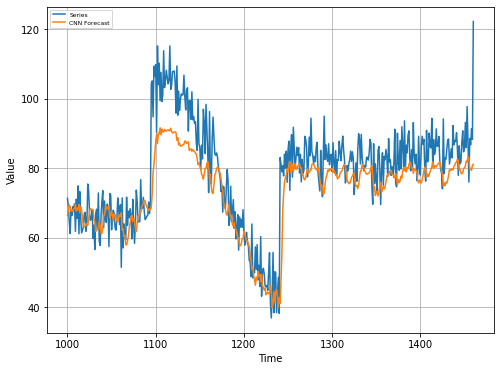

In [11]:
plt.figure(figsize=(8,6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, cnn_forecast, label='CNN Forecast')
plt.show()

In [12]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

6.886451

In [20]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 16, 32, 64):
  model.add(tf.keras.layers.Conv1D(filters=32,
                                   kernel_size=5,
                                   strides=1,
                                   dilation_rate=dilation_rate,
                                   padding='causal',
                                   activation='relu'))
model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-06)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 1s 17ms/step - loss: 42.5708 - mae: 43.0699 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 42.5707 - mae: 43.0699 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 42.5707 - mae: 43.0698 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 42.5707 - mae: 43.0698 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 42.5707 - mae: 43.0698 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 42.5706 - mae: 43.0698 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 12ms/step - loss: 42.5706 - mae: 43.0697 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 13ms/step - loss: 42.5706 - mae: 43.0697 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 42.5705 - mae: 43.0697 - lr: 2.5

(1e-05, 0.01, 0.0, 30.0)

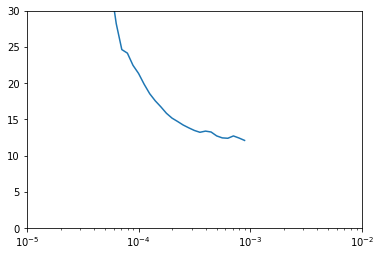

In [26]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-5, 1e-2, 0, 30])

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 16, 32, 64):
  model.add(tf.keras.layers.Conv1D(filters=32,
                                   kernel_size=5,
                                   strides=1,
                                   dilation_rate=dilation_rate,
                                   padding='causal',
                                   activation='relu'))
model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-03)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=['mae'])
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_checkpoint.h5', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 2s 115ms/step - loss: 40.5653 - mae: 41.0645 - val_loss: 65.0625 - val_mae: 65.5625
Epoch 2/500
8/8 [==============================] - 0s 31ms/step - loss: 29.1431 - mae: 29.6406 - val_loss: 41.6167 - val_mae: 42.1147
Epoch 3/500
8/8 [==============================] - 0s 29ms/step - loss: 23.7606 - mae: 24.2565 - val_loss: 33.8314 - val_mae: 34.3273
Epoch 4/500
8/8 [==============================] - 0s 30ms/step - loss: 19.7012 - mae: 20.1947 - val_loss: 22.8599 - val_mae: 23.3508
Epoch 5/500
8/8 [==============================] - 0s 34ms/step - loss: 16.6334 - mae: 17.1246 - val_loss: 20.2034 - val_mae: 20.6966
Epoch 6/500
8/8 [==============================] - 0s 30ms/step - loss: 15.3859 - mae: 15.8764 - val_loss: 17.5386 - val_mae: 18.0313
Epoch 7/500
8/8 [==============================] - 0s 30ms/step - loss: 14.1302 - mae: 14.6182 - val_loss: 16.2208 - val_mae: 16.7114
Epoch 8/500
8/8 [==============================] - 0s 29ms/st

In [15]:
model = tf.keras.models.load_model('model_checkpoint.h5')

In [17]:
cnn_forecast2 = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast2 = cnn_forecast2[split_time-window_size:-1, -1, 0]

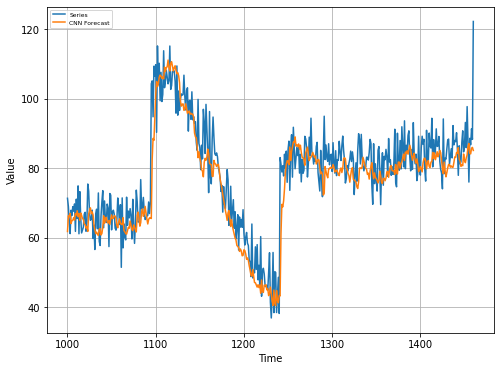

In [18]:
plt.figure(figsize=(8,6))
plot_series(time_valid, x_valid, label='Series')
plot_series(time_valid, cnn_forecast2, label='CNN Forecast')
plt.show()

In [19]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast2).numpy()

5.3528657